In [1]:
import ee
ee.Initialize ()

In [2]:
from iteru import *
from IPython.display import display
import ipywidgets
import datetime

In [3]:
Map = Map()
Map

Map(center=[27, 31], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Sea…

In [37]:
aoi = ee.Geometry.Polygon ([[[
              35.008243,
              10.522199
            ],
            [
              35.008243,
              11.266588
            ],
            [
              35.387092,
              11.266588
            ],
            [
              35.387092,
              10.522199
            ],
            [
              35.008243,
              10.522199
            ]]])

In [38]:
start_year = 2020
start_month =1
start_day = 1
end_year = 2022
end_month = 3
end_day = 1
time_delta = 30
water_threshold = -18

In [39]:
start_date = datetime.date(start_year,start_month,start_day)
end_date = datetime.date(end_year,end_month,end_day)
ee_start_date = f'{start_year}-{start_month}-{start_day}'
ee_end_date = f'{end_year}-{end_month}-{end_day}'

In [40]:
dates_list = get_dates_sequence(start_date ,end_date, time_delta)

In [41]:
SAR = ee.ImageCollection('COPERNICUS/S1_GRD')\
     .filter(ee.Filter.equals('relativeOrbitNumber_start', 50))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('resolution_meters',10))\
    .filterBounds(aoi)\
    .filterDate(ee_start_date,ee_end_date)\
    .select(['VV','VH'])

In [42]:
SAR = SAR.map(addRatioBand)

In [43]:
def filterSpeckles(img):
    
    VV_smooth = img.select('VV').focal_median(100,'circle','meters').rename('VV_Filtered')
    
    return img.addBands(VV_smooth)

In [44]:
SAR = SAR.map(filterSpeckles)

In [45]:
def water_classify(img):
    vv  = img.select('VV_Filtered')
    water = vv.lt(water_threshold).rename('Water')
    water_mask = water.updateMask(water).rename('Water_mask')
    return img.addBands([water,water_mask])

In [46]:
SAR = SAR.map(water_classify)

In [47]:
def rgb_w_water_mask(img):
    
    img_rgb = img.visualize(**{'min':[-25,-25,0],'max':[0,0,2],'bands':['VV','VH','VV/VH']})
    
    water_vis = img.select('Water_mask').visualize(**{'min': 0.5,'max': 1,'palette': ['00FFFF', '0000FF']})
                  
    mosaic = ee.ImageCollection([img_rgb,water_vis]).mosaic()
 
    return mosaic.copyProperties(img, img.propertyNames())


In [49]:
SAR = SAR.map(rgb_w_water_mask)

In [17]:
# Map.add_layer_widgets(SAR,{'bands':'VV_Filtered_median','min':-25,'max':5},'TEST_SAR')

In [18]:
# Map.add_layer_widgets(z,{'bands':'Water_mask_median','palette': ['00FFFF', '0000FF']},'TEST_SAR_WATER_MASK')

In [19]:
# Map.add_layer_widgets(SAR,{'min':[-25,-25,0],'max':[0,0,2],'bands':['VV','VH','VV/VH']},'SAR')

In [50]:
def get_images(day_date):
    
    start_day = ee.Date(day_date)
    end_day = start_day.advance(time_delta,'day')
    
    return SAR.filterDate(start_day,end_day).median()\
          .set({'start_day':start_day.format('YYYY-MM-dd')})\
          .set({'end_day':end_day.format('YYYY-MM-dd')})

In [51]:
images = ee.List(dates_list).map(get_images)

In [52]:
collection = ee.ImageCollection.fromImages(images)

In [53]:
collection.size().getInfo()

26

In [24]:
# z = collection.filter(ee.Filter.eq('start_day','2021-08-25'))

In [54]:
videoArgs = {
  'dimensions': 900 ,
  'region': aoi,
  'framesPerSecond':2,
  'crs': 'EPSG:3857',
#   'min':[-25,-25,0],
#   'max':[0,0,5],
#   'bands':['VV_median','VH_median','VV/VH_median']
#   'bands':['Water_mask'],
#   'palette': ['00FFFF', '0000FF'],
  'palette':None,
#   'min':[0.5],
#     'max':[1],
  'bands':['vis-red','vis-green','vis-blue'],
   'min':0,
   'max':255
   
     }

In [55]:
url = collection.getVideoThumbURL(videoArgs)

In [56]:
out_gif = get_gif(url)

In [57]:
add_text_to_gif(out_gif,dates_list, dates_font_size = 25, dates_font_color = 'black', framesPerSecond = 2 )

In [58]:
display_gif(out_gif)

Output()

In [28]:
def calc_area(feature):
    
    area = feature.geometry().area(maxError = 1)
    
    return feature.set({'Area':area})

In [29]:
def water_to_vector(img):
    
    water_mask = img.select('Water_mask').clip(aoi)
    
    feature = ee.Image(1).updateMask(water_mask).reduceToVectors(
           geometry = water_mask.geometry(),
           crs ='EPSG:32636',
           scale = 10 , 
           geometryType = 'polygon',
           eightConnected = False,
           labelProperty =  'water_cover',
           bestEffort = True
          )
    feature = feature.map(calc_area)
    
    lake_feature = feature.sort('Area', False).first()
    
    lake_area = lake_feature.geometry().area(maxError = 1) 
    
    return ee.FeatureCollection(lake_feature).set({'Area':lake_area})\
           .copyProperties(img, img.propertyNames())\
           .copyProperties(lake_feature, lake_feature.propertyNames())
    

In [30]:
water_vectors = collection.map(water_to_vector)

In [31]:
water_area = [area /(1e6) for area in water_vectors.aggregate_array('Area').getInfo()]

In [32]:
import matplotlib.pyplot as plt

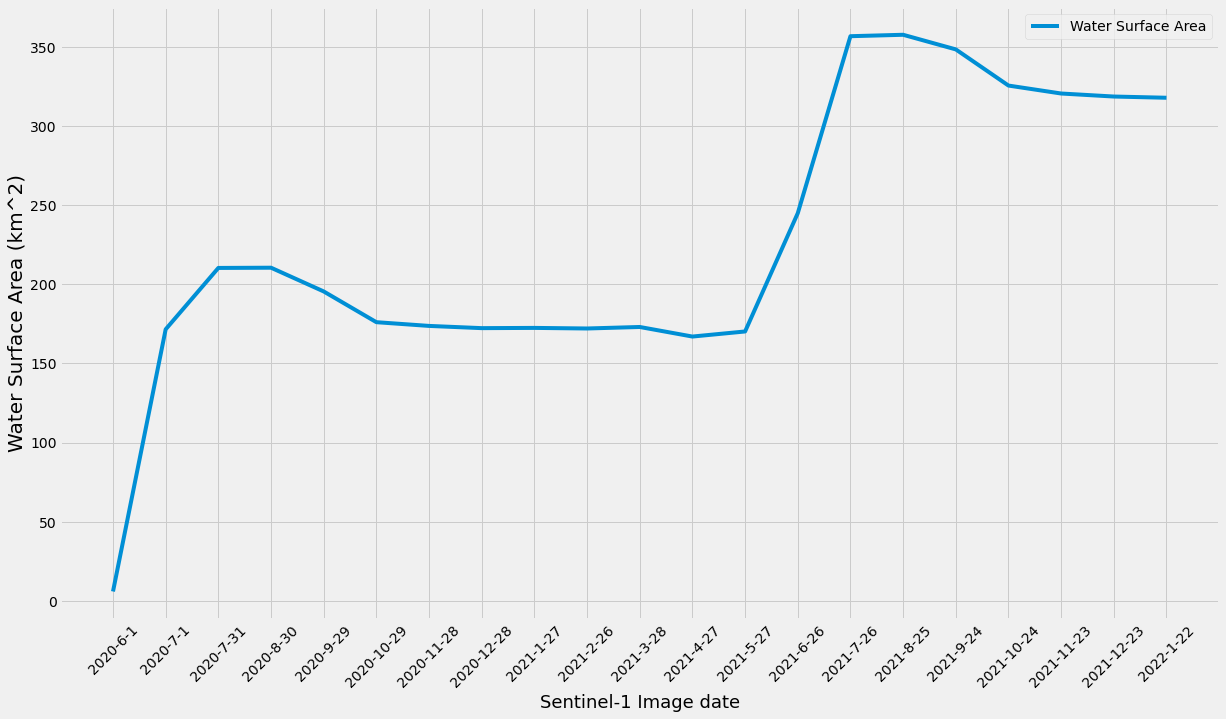

In [33]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-1 Image date',fontsize=18)
plt.ylabel('Water Surface Area (km^2)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,water_area,label ='Water Surface Area')
plt.legend()
plt.gcf().set_size_inches(18.5,10.5)

In [34]:
elevation_dataset = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2')\
           .filter(ee.Filter.bounds(aoi))\
           .select('DSM')\
           .median()\
           .clip(aoi)\
           .reproject(crs = 'EPSG:32636', scale = 30 )

In [35]:
def max_water_ele(feature):
    
    lake_dem = elevation_dataset.clip(feature)
    
    max_ele = lake_dem.reduceRegion(
                         reducer = ee.Reducer.max(),
                         geometry = lake_dem.geometry(), 
                         scale = 30, 
                         crs = 'EPSG:32636',
                        maxPixels = 1e11).get('DSM')
    return lake_dem.set({'Maximum_water_elevation':max_ele,'Image_date':feature.get('start_day')})
    

In [36]:
dems = water_vectors.map(max_water_ele)

In [37]:
max_elev = [elev for elev in dems.aggregate_array('Maximum_water_elevation').getInfo()]

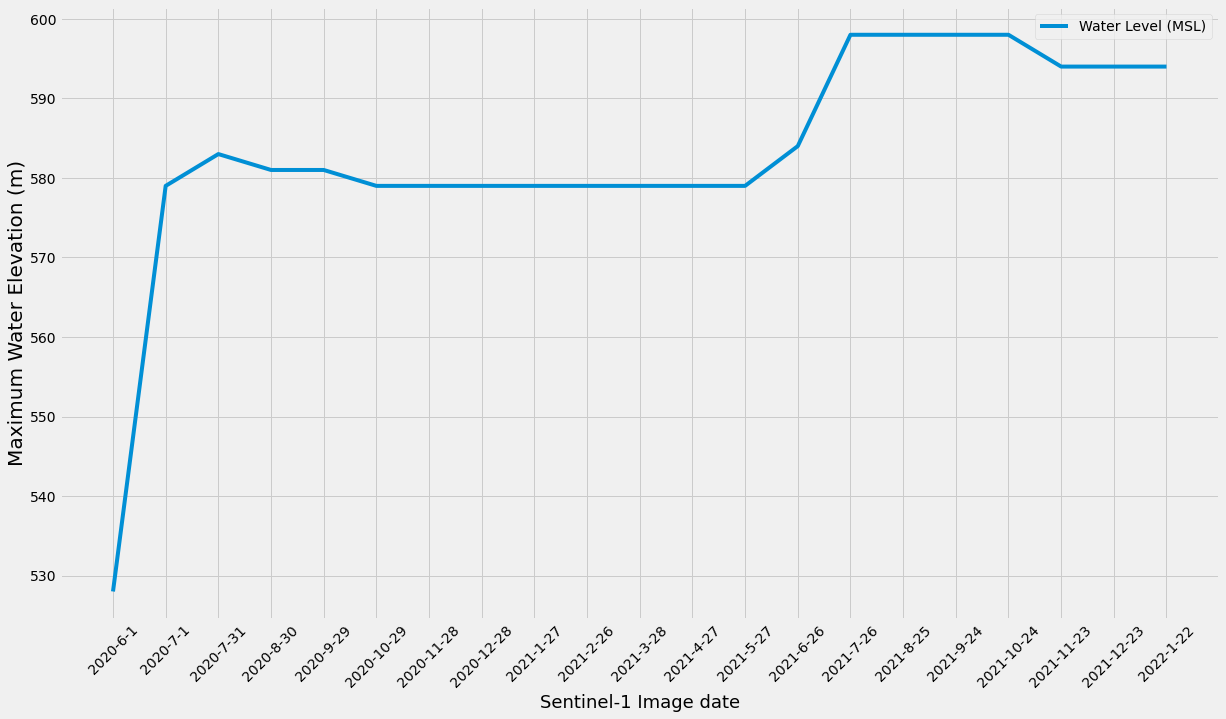

In [38]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-1 Image date',fontsize=18)
plt.ylabel('Maximum Water Elevation (m)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,max_elev, label = 'Water Level (MSL)')
plt.legend()
plt.gcf().set_size_inches(18.5,10.5)

In [39]:
def water_vol(lake_dem):
    
    elevations = lake_dem.reduceRegion(
        reducer=ee.Reducer.toList(), 
        geometry=lake_dem.geometry(),
        maxPixels=1e11,
        scale=30,
        crs = 'EPSG:32636',
        bestEffort = True
    ).get('DSM')
    
    elev_pixles_num = ee.List(elevations).length()
    
    elev_sum = ee.List(elevations).reduce(ee.Reducer.sum())
    
    stats = {'Pixels_number':elev_pixles_num,
             'Elevation_sum': elev_sum
            }
    
    return ee.Feature(None,stats)

In [40]:
volume_stats = dems.map(water_vol)

In [41]:
ele_sum = volume_stats.aggregate_array('Elevation_sum').getInfo()

In [42]:
pixel_num  = volume_stats.aggregate_array('Pixels_number').getInfo()

In [43]:
volume = [((water_level*pixles_count-elevations_sum)*900)/(1e9) for water_level,elevations_sum , pixles_count in zip(max_elev,ele_sum,pixel_num)]
    

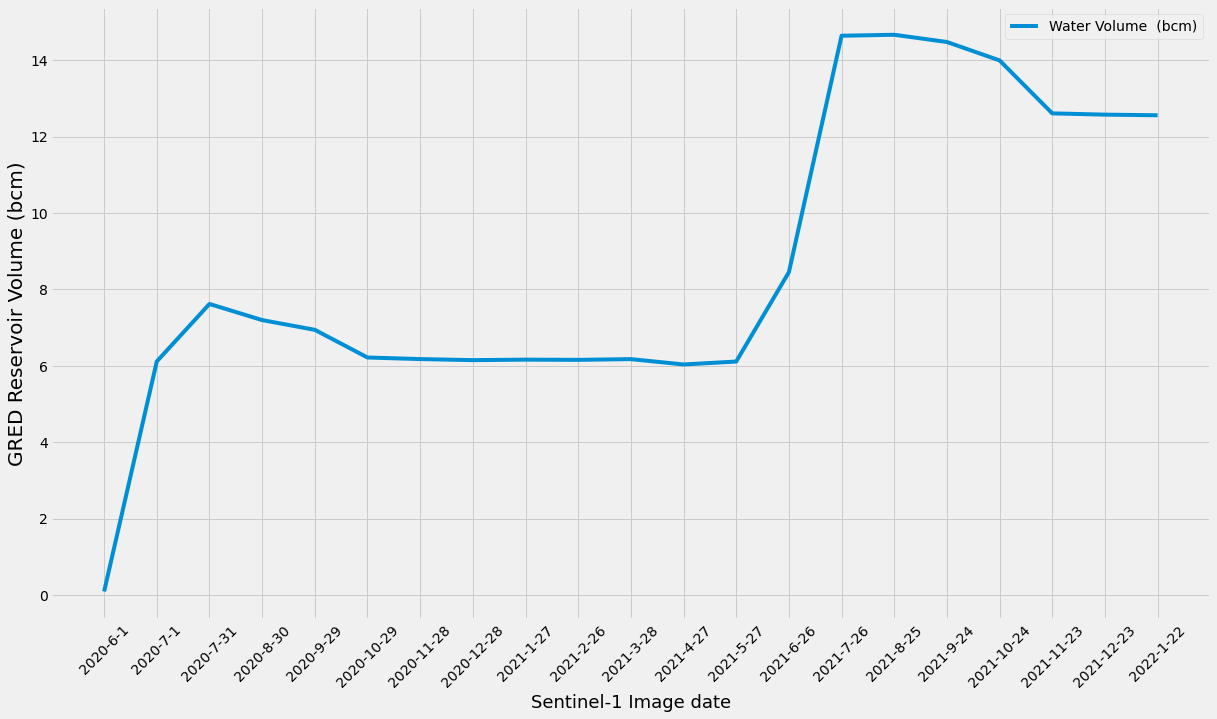

In [44]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-1 Image date',fontsize=18)
plt.ylabel('GRED Reservoir Volume (bcm)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,volume,label = 'Water Volume  (bcm)')
plt.legend()
plt.gcf().set_size_inches(18.5,10.5)